100%|██████████| 170M/170M [00:01<00:00, 90.6MB/s] 


Dataset → Train: 45000 | Val: 5000 | Test: 10000
[Ep   1] TrainAcc=0.3775 | ValAcc=0.4470 | TestAcc=0.4830 | Reward=+41.68 | Opt=SGD | Δt=15.0s
[Ep   2] TrainAcc=0.4946 | ValAcc=0.5270 | TestAcc=0.5568 | Reward=+6.86 | Opt=SGD | Δt=13.5s
[Ep   3] TrainAcc=0.5612 | ValAcc=0.5706 | TestAcc=0.5848 | Reward=+3.08 | Opt=SGD | Δt=13.8s
[Ep   4] TrainAcc=0.6096 | ValAcc=0.6234 | TestAcc=0.6506 | Reward=+4.10 | Opt=SGD | Δt=13.4s
[Ep   5] TrainAcc=0.5948 | ValAcc=0.6208 | TestAcc=0.6463 | Reward=-1.69 | Opt=ADAM | Δt=14.2s
[Ep   6] TrainAcc=0.6682 | ValAcc=0.6646 | TestAcc=0.6877 | Reward=+2.66 | Opt=SAM | Δt=18.5s
[Ep   7] TrainAcc=0.6645 | ValAcc=0.6724 | TestAcc=0.6931 | Reward=-0.60 | Opt=ADAM | Δt=13.9s
[Ep   8] TrainAcc=0.7120 | ValAcc=0.7100 | TestAcc=0.7264 | Reward=+2.06 | Opt=SAM | Δt=18.2s
[Ep   9] TrainAcc=0.7020 | ValAcc=0.6904 | TestAcc=0.7078 | Reward=-3.43 | Opt=ADAM | Δt=14.0s
[Ep  10] TrainAcc=0.7442 | ValAcc=0.7280 | TestAcc=0.7522 | Reward=+2.09 | Opt=SAM | Δt=17.9s
[Ep  11

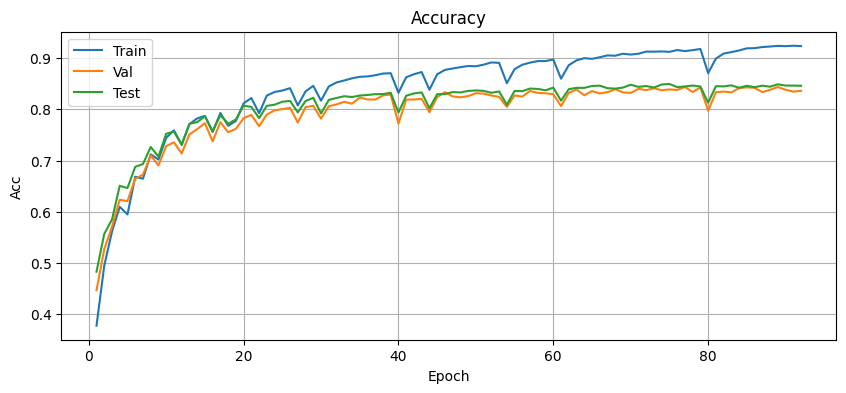

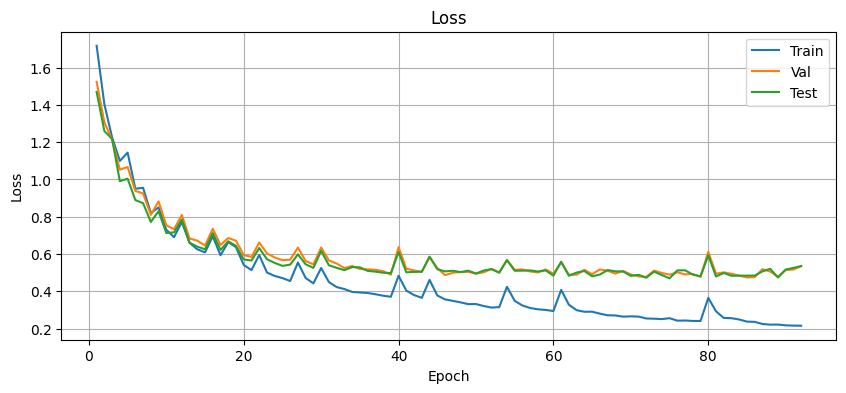


===== FINAL TEST METRICS =====
Accuracy : 0.8459
F1 score : 0.8457
Precision: 0.8459


In [1]:
# =============================================================
# optimizer_rl_selector.py  — v18 (robust, runnable on Kaggle)
# -------------------------------------------------------------
#  • Dataset : CIFAR‑10 (train / val / test) with augmentation
#  • Model   : ResNet‑18 (scratch)
#  • RL      : PPO selects optimizer {SGD, Adam, SAM}
#              Updates every ROLLOUT_STEPS epochs
#  • Reward  : 100·ΔAcc – ΔLoss – 0.1·epoch_time
# =============================================================

import math, random, time, numpy as np, matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as tdist
from sklearn.metrics import accuracy_score, f1_score, precision_score  # added metrics imports  # Categorical
from torch import optim
from sklearn.metrics import accuracy_score, f1_score, precision_score

from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split
import torchvision.models as models

import builtins, functools  # auto‑flush printing
print = functools.partial(builtins.print, flush=True)

# ------------------------------ 0. Hyper‑params ------------------------
DEVICE         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED           = 42
ROLLOUT_STEPS  = 4
GAMMA          = 0.99
LAMBDA_GAE     = 0.95
PPO_EPOCHS     = 4
CLIP_EPS       = 0.2
ENT_COEF       = 1e-2
LR_POLICY      = 3e-4
LR_VALUE       = 1e-3
STATE_DIM      = 6     # [val_acc, val_loss, Δacc, Δloss, epoch%, prev_act]
ACTION_DIM     = 3     # 0=SGD, 1=Adam, 2=SAM
W_ACC, W_LOSS, W_TIME = 100.0, 1.0, 0.1

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ------------------------------ 1. Custom SAM -------------------------
class SAM(optim.Optimizer):
    """Sharpness‑Aware Minimization (two‑step)"""
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        if rho <= 0:
            raise ValueError("rho must be positive")
        defaults = dict(rho=rho, **kwargs)
        super().__init__(params, defaults)
        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)

    @torch.no_grad()
    def first_step(self, zero_grad: bool = False):
        grad_norm = torch.norm(torch.stack([
            p.grad.norm()
            for group in self.param_groups for p in group['params'] if p.grad is not None
        ]))
        for group in self.param_groups:
            scale = group['rho'] / (grad_norm + 1e-12)
            for p in group['params']:
                if p.grad is None:
                    continue
                e_w = p.grad * scale
                p.add_(e_w)
                self.state[p]['e_w'] = e_w.detach()
        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad: bool = False):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                p.sub_(self.state[p]['e_w'])
        self.base_optimizer.step()
        if zero_grad:
            self.zero_grad()

# ------------------------------ 2. Model ------------------------------

def get_resnet18_scratch(num_classes: int = 10):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# ------------------------------ 3. Data --------------------------------

def load_cifar10(batch_train: int = 128, batch_eval: int = 256):
    tf_train = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    tf_eval = T.Compose([
        T.ToTensor(),
        T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    full_train = CIFAR10(root='./data', train=True, download=True, transform=tf_train)
    test_set   = CIFAR10(root='./data', train=False, download=True, transform=tf_eval)

    n_val = 5_000
    train_ds, val_ds = random_split(full_train, [len(full_train) - n_val, n_val],
                                    generator=torch.Generator().manual_seed(SEED))

    dl_train = DataLoader(train_ds, batch_size=batch_train, shuffle=True,  num_workers=2, pin_memory=True)
    dl_val   = DataLoader(val_ds,   batch_size=batch_eval,  shuffle=False, num_workers=2, pin_memory=True)
    dl_test  = DataLoader(test_set, batch_size=batch_eval,  shuffle=False, num_workers=2, pin_memory=True)

    print(f"Dataset → Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_set)}")
    return dl_train, dl_val, dl_test

# ------------------------------ 4. RL Networks -------------------------
class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(STATE_DIM, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, ACTION_DIM)
        )
    def forward(self, x):
        return self.net(x)

class ValueNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(STATE_DIM, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

# ------------------------------ 5. RolloutBuffer -----------------------
class RolloutBuffer:
    def __init__(self):
        self.clear()
    def store(self, s, a, logp, v, r, d):
        # ensure detaching from graph
        self.states.append(s.detach())
        self.actions.append(a.detach())
        self.logprobs.append(logp.detach())
        self.values.append(v.detach())
        # reward might be float or tensor
        if isinstance(r, torch.Tensor):
            self.rewards.append(r.detach())
        else:
            self.rewards.append(torch.tensor(r, dtype=torch.float32, device=DEVICE))
        self.dones.append(torch.tensor(d, dtype=torch.float32, device=DEVICE))
    # alias for compatibility
    add = store

    def compute_adv_returns(self, next_value: torch.Tensor):
        self.advs, self.rets = [], []
        adv = 0.0
        for i in reversed(range(len(self.rewards))):
            mask  = 1.0 - self.dones[i]
            delta = self.rewards[i] + GAMMA * next_value * mask - self.values[i]
            adv   = delta + GAMMA * LAMBDA_GAE * mask * adv
            self.advs.insert(0, adv)
            self.rets.insert(0, adv + self.values[i])
            next_value = self.values[i]
    def as_tensors(self):
        def _stk(seq):
            return seq if isinstance(seq, torch.Tensor) else torch.stack(seq)
        return (
            _stk(self.states).to(DEVICE),
            _stk(self.actions).to(DEVICE),
            _stk(self.logprobs).to(DEVICE),
            _stk(self.advs).to(DEVICE),
            _stk(self.rets).to(DEVICE)
        )
    def clear(self):
        self.states, self.actions, self.logprobs = [], [], []
        self.rewards, self.values, self.dones    = [], [], []
        self.advs, self.rets = [], []
# ------------------------------ 6. Optimizer factory ------------------- -------------------

def make_optimizer(name: str, model: nn.Module, lr: float):
    if name == 'sgd':
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    if name == 'adam':
        return optim.Adam(model.parameters(), lr=lr)
    if name == 'sam':
        return SAM(model.parameters(), base_optimizer=optim.SGD, lr=lr, momentum=0.9)
    raise ValueError(f"Unknown optimizer {name}")

ID2OPT = ['sgd', 'adam', 'sam']

# ------------------------------ 7. Trainer -----------------------------
class OptimizerRLTrainer:
    def __init__(self, model, dl_train, dl_val, dl_test, n_epochs: int = 30, patience: int = 10):
        self.model = model.to(DEVICE)
        self.dl_train, self.dl_val, self.dl_test = dl_train, dl_val, dl_test
        self.n_epochs, self.patience = n_epochs, patience

        # RL nets
        self.policy, self.value = PolicyNet().to(DEVICE), ValueNet().to(DEVICE)
        self.opt_policy = optim.Adam(self.policy.parameters(), lr=LR_POLICY)
        self.opt_value  = optim.Adam(self.value.parameters(),  lr=LR_VALUE)

        # Optimizer pool
        self.opt_pool = {
            'sgd' : make_optimizer('sgd',  self.model, lr=1e-2),
            'adam': make_optimizer('adam', self.model, lr=1e-3),
            'sam' : make_optimizer('sam',  self.model, lr=1e-2)
        }

        self.hist = {k: [] for k in ['train_acc','val_acc','test_acc',
                                     'train_loss','val_loss','test_loss',
                                     'reward','action']}

    # ---------- util evaluation ----------
    def _eval_loader(self, loader):
        self.model.eval()
        loss_fn = nn.CrossEntropyLoss()
        tot_loss, tot_correct, n = 0.0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                logits = self.model(x)
                loss   = loss_fn(logits, y)
                tot_loss += loss.item() * y.size(0)
                preds = logits.argmax(1)
                tot_correct += (preds == y).sum().item(); n += y.size(0)
        return tot_correct/n, tot_loss/n

    # ---------- PPO update ----------
    def _ppo_update(self, buffer: RolloutBuffer):
        states, actions, old_logp, advs, rets = buffer.as_tensors()
        advs = (advs - advs.mean()) / (advs.std() + 1e-8)
        for _ in range(PPO_EPOCHS):
            logits = self.policy(states)
            dist   = tdist.Categorical(logits=logits)
            logp   = dist.log_prob(actions)
            ratio  = torch.exp(logp - old_logp)
            surr1  = ratio * advs
            surr2  = torch.clamp(ratio, 1-CLIP_EPS, 1+CLIP_EPS) * advs
            policy_loss = -(torch.min(surr1, surr2) + ENT_COEF * dist.entropy()).mean()

            self.opt_policy.zero_grad(); policy_loss.backward(); self.opt_policy.step()

            value_pred = self.value(states)
            value_loss = F.mse_loss(value_pred, rets)
            self.opt_value.zero_grad(); value_loss.backward(); self.opt_value.step()

    # ---------- main training ----------
    def fit(self):
        loss_fn = nn.CrossEntropyLoss()
        buffer  = RolloutBuffer()
        best_val, patience_cnt = 0.0, 0
        prev_val_acc, prev_val_loss, prev_act_id = 0.0, 0.0, 0

        for ep in range(self.n_epochs):
            ep_start = time.time()
            self.model.train()

            # ---- construct state & pick optimizer ----
            state_vec = torch.tensor([
                prev_val_acc, prev_val_loss, 0.0, 0.0,
                ep / self.n_epochs,
                prev_act_id / (ACTION_DIM-1)
            ], dtype=torch.float32, device=DEVICE)
            logits = self.policy(state_vec)
            dist   = tdist.Categorical(logits=logits)
            act_id = dist.sample()
            logp   = dist.log_prob(act_id)
            opt_name = ID2OPT[act_id.item()]
            optimizer = self.opt_pool[opt_name]

            # ---- one training epoch ----
            tot_loss, tot_correct, n = 0.0, 0, 0
            for x, y in self.dl_train:
                x, y = x.to(DEVICE), y.to(DEVICE)
                optimizer.zero_grad()
                logits_cls = self.model(x)
                loss = loss_fn(logits_cls, y)
                if opt_name == 'sam':
                    loss.backward()
                    optimizer.first_step(zero_grad=True)
                    loss_sam = loss_fn(self.model(x), y)
                    loss_sam.backward(); optimizer.second_step(zero_grad=True)
                else:
                    loss.backward(); optimizer.step()
                tot_loss += loss.item() * y.size(0)
                tot_correct += (logits_cls.argmax(1) == y).sum().item(); n += y.size(0)
            train_acc, train_loss = tot_correct/n, tot_loss/n

            # ---- evaluation ----
            val_acc, val_loss   = self._eval_loader(self.dl_val)
            test_acc, test_loss = self._eval_loader(self.dl_test)

            # ---- reward ----
            delta_acc  = val_acc - prev_val_acc
            delta_loss = prev_val_loss - val_loss
            epoch_time = time.time() - ep_start
            reward_val = W_ACC*delta_acc + W_LOSS*delta_loss - W_TIME*epoch_time
            reward = torch.tensor(reward_val, dtype=torch.float32, device=DEVICE)

            # ---- store rollout ----
            next_state_vec = torch.tensor([
                val_acc, val_loss, delta_acc, delta_loss,
                (ep+1) / self.n_epochs,
                act_id.item() / (ACTION_DIM-1)
            ], dtype=torch.float32, device=DEVICE)
            buffer.store(state_vec, act_id, logp, self.value(state_vec).detach(), reward, False)

            if (ep+1) % ROLLOUT_STEPS == 0 or ep == self.n_epochs-1:
                buffer.compute_adv_returns(torch.tensor(0.0, device=DEVICE))
                self._ppo_update(buffer); buffer.clear()

            # ---- history ----
            self.hist['train_acc'].append(train_acc);  self.hist['train_loss'].append(train_loss)
            self.hist['val_acc'].append(val_acc);      self.hist['val_loss'].append(val_loss)
            self.hist['test_acc'].append(test_acc);    self.hist['test_loss'].append(test_loss)
            self.hist['reward'].append(reward_val);    self.hist['action'].append(act_id.item())

            print(f"[Ep {ep+1:3}] TrainAcc={train_acc:.4f} | ValAcc={val_acc:.4f} | "
                  f"TestAcc={test_acc:.4f} | Reward={reward_val:+.2f} | Opt={opt_name.upper()} | "
                  f"Δt={epoch_time:.1f}s")

            # ---- early stopping ----
            if val_acc > best_val:
                best_val, patience_cnt = val_acc, 0
            else:
                patience_cnt += 1
                if patience_cnt >= self.patience:
                    print(f"Early stopped at epoch {ep+1}")
                    break

            prev_val_acc, prev_val_loss, prev_act_id = val_acc, val_loss, act_id.item()

        # ---------------- plots ----------------
        epochs = range(1, len(self.hist['train_acc'])+1)
        plt.figure(figsize=(10,4))
        plt.plot(epochs, self.hist['train_acc'], label='Train')
        plt.plot(epochs, self.hist['val_acc'],   label='Val')
        plt.plot(epochs, self.hist['test_acc'],  label='Test')
        plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Acc'); plt.legend(); plt.grid(); plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(epochs, self.hist['train_loss'], label='Train')
        plt.plot(epochs, self.hist['val_loss'],   label='Val')
        plt.plot(epochs, self.hist['test_loss'],  label='Test')
        plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(); plt.show()

        # ---------------- final metrics ----------------
        self.model.eval(); preds_all, labels_all = [], []
        with torch.no_grad():
            for x, y in self.dl_test:
                x, y = x.to(DEVICE), y.to(DEVICE)
                logits = self.model(x)
                preds_all.append(logits.argmax(1).cpu())
                labels_all.append(y.cpu())
        preds_all  = torch.cat(preds_all)
        labels_all = torch.cat(labels_all)

        print("\n===== FINAL TEST METRICS =====")
        print(f"Accuracy : {accuracy_score(labels_all,preds_all):.4f}")
        print(f"F1 score : {f1_score(labels_all,preds_all,average='weighted'):.4f}")
        print(f"Precision: {precision_score(labels_all,preds_all,average='weighted'):.4f}")

# ------------------------------ 8. Main ------------------------------
if __name__ == '__main__':
    dl_train, dl_val, dl_test = load_cifar10()
    model = get_resnet18_scratch()
    trainer = OptimizerRLTrainer(model, dl_train, dl_val, dl_test, n_epochs=150, patience=15)
    trainer.fit()
